In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, measure
from tqdm import tqdm

(517, 517) (517, 517, 3)


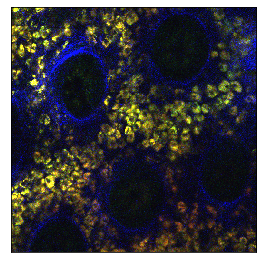

In [3]:
mask = io.imread('mask1.png')
image = io.imread('stack1.tif')
print(
    mask.shape,
    image.shape)
io.imshow(image); plt.xticks([]); plt.yticks([]);

# Segment via cellpose

In [4]:
from cellpose import models, io
model = models.Cellpose(gpu=False, model_type='cyto')
channels = [0,0]

/opt/homebrew/anaconda3/envs/sci/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [43]:
masks, flows, styles, diams = model.eval(image[:,:,0], channels=channels, flow_threshold=.8)

In [44]:
io.masks_flows_to_seg(image, masks, flows, diams, 'test.png', channels)
io.save_to_png(image, masks, flows, 'test.png')


 99%|█████████▉| 164/165 [00:00<00:00, 326.42it/s]


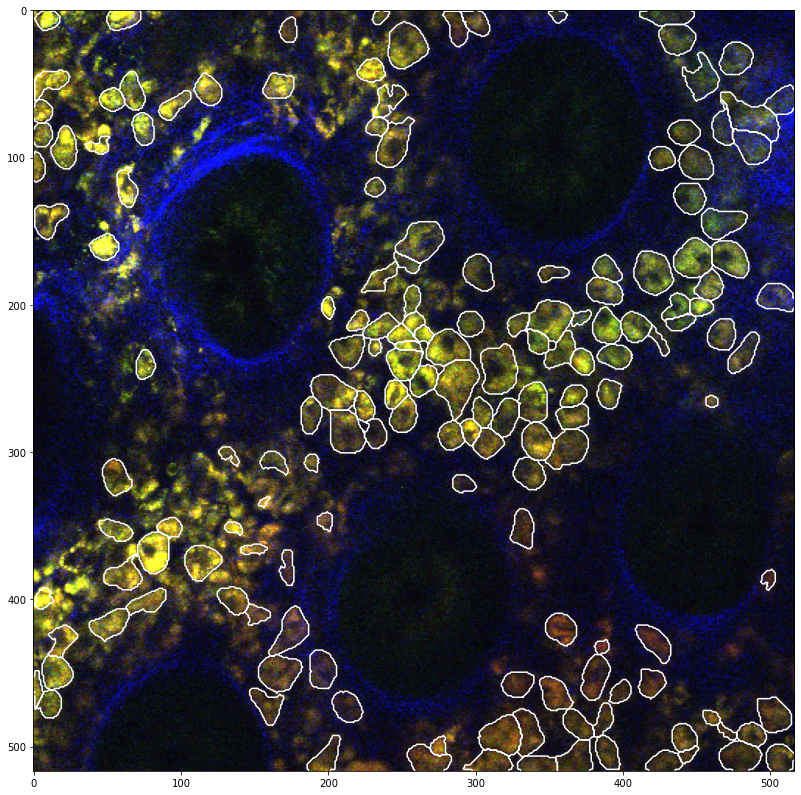

In [45]:
fig = plt.figure(figsize=(14,14))
plt.imshow(image)

pbar = tqdm(total=masks.max())
for i in range(1,masks.max()):
    pbar.update()
    contours = measure.find_contours(masks == i)
    plt.imshow(image)
    for contour in contours:
        line = plt.plot(contour[:,1], contour[:,0], color='white')
    # if i == 2: break

pbar.close()

# 3D cellpose
To make it work, we need to enable *anisotropy* parameter. It is required because the sampling was not equal in XY and Z direction. Z / XY = 1.2925


In [51]:
stack = io.imread('../4 Raw data/1c-small.tif')
stack.shape

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


(67, 100, 105)

In [49]:
model = models.Cellpose(gpu=False, model_type='cyto')
channels = [0,0]

In [64]:
masks, flows, styles, diams = model.eval(stack, channels=channels, flow_threshold=.8, anisotropy=1.2925, stitch_threshold=.5)

In [65]:
from skimage import io as sio
sio.imsave('masks.tif', masks)

/opt/homebrew/anaconda3/envs/sci/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: masks.tif is a low contrast image
  


# Checking the cell area distribution

100%|█████████▉| 208/209 [00:00<00:00, 4426.46it/s]


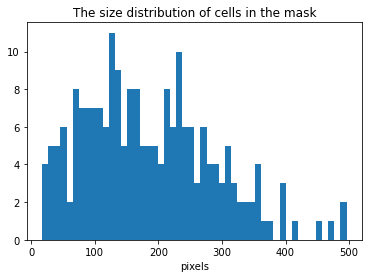

In [55]:
stats = []
N = mask.max()+1
pbar = tqdm(total=N)
for i in range(1,N):
    seg = mask == i
    size = np.sum(seg)
    stats.append(size)
    pbar.update(1)

pbar.close()

plt.title('The size distribution of cells in the mask')
plt.xlabel('pixels')
plt.hist(stats, 50);

# Visualization of segmented cells

In [56]:
def bbox(seg):
    """
    Compute the bounding box of a segmentation.
    """
    rows = np.any(seg, axis=1)
    cols = np.any(seg, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

In [ ]:
imin, imax = 1, np.max(mask)
o = 5
for i in range(imin, imax+1):
    seg = mask == i
    if np.sum(seg) > 100:
        try:
            ymin, ymax, xmin, xmax = bbox(seg)
            plt.imshow(image[ymin-o:ymax+1+o, xmin-o:xmax+1+o])
            # plt.imshow(seg[ymin:ymax+1, xmin:xmax+1], cmap='plasma', alpha=0.5)
            plt.show()
        except:
            pass
    
